In [20]:
from qiskit_ibm_provider import IBMProvider
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qiskit import pulse, IBMQ
from qiskit.pulse import transforms, Acquire, AcquireChannel, MemorySlot, Schedule, Play
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.circuit import Gate
from qiskit.pulse import library
from qiskit import QuantumCircuit
from qiskit import transpile, schedule as build_schedule
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-internal', group='dev-qiskit', project='ignis')
# backend = provider.get_backend('test_whiplash')

provider = IBMProvider(name="dev-iqp")
backend = provider.get_backend("test_whiplash")
pi=np.pi

In [59]:
config = backend.configuration()
props = backend.properties()

np.abs(props.frequency(7)-props.frequency(6)) * props.gate_length('x',6)*2 - pi

1.1495340179990192

In [9]:
#This section makes a list of circuits for running the spectator expt using circuit building method
N_angles = 31
N_iterations = 5
mults = 1
total_shots = 200
angle_min = -pi
angle_max = pi

qc = [QuantumCircuit(2,2) for n in range(2*N_angles*N_iterations)]
phi_list = np.linspace(angle_min,angle_max,N_angles)

circ_list = []

idx = 0
for k in range(2):
    if k == 0:
        yprep = [pi/2,-pi/2]
    if k == 1:
        yprep = [-pi/2,pi/2]
    # for i in range(N_angles):
    for i in range(1):
        for j in range(N_iterations):
            phi = phi_list[i]
            phi = 0.1
            total_reps = j*mults
            qc[idx].ry(yprep[0],0)
            qc[idx].barrier()
            for rep in range(total_reps):
                # qc[idx].barrier()
                qc[idx].rz(-rep*phi,0)
                qc[idx].barrier()
                qc[idx].x(0)
                qc[idx].barrier()
                qc[idx].rz(rep*phi,0)
                # qc[idx].barrier()
                qc[idx].rz(-phi/2-rep*phi,0)
                qc[idx].barrier()
                qc[idx].x(0)
                qc[idx].barrier()
                qc[idx].rz(phi/2+rep*phi,0)
            # qc[idx].barrier()
            qc[idx].rz(-(total_reps)*phi,0)
            qc[idx].barrier()
            qc[idx].ry(yprep[1],0)
            qc[idx].barrier()
            qc[idx].measure([0,1],[0,1])
            qc[idx].barrier()
            circ_list.append(transpile(qc[idx],backend,initial_layout=[6,7],scheduling_method='alap'))
            idx+=1



In [7]:
len(circ_list)

10

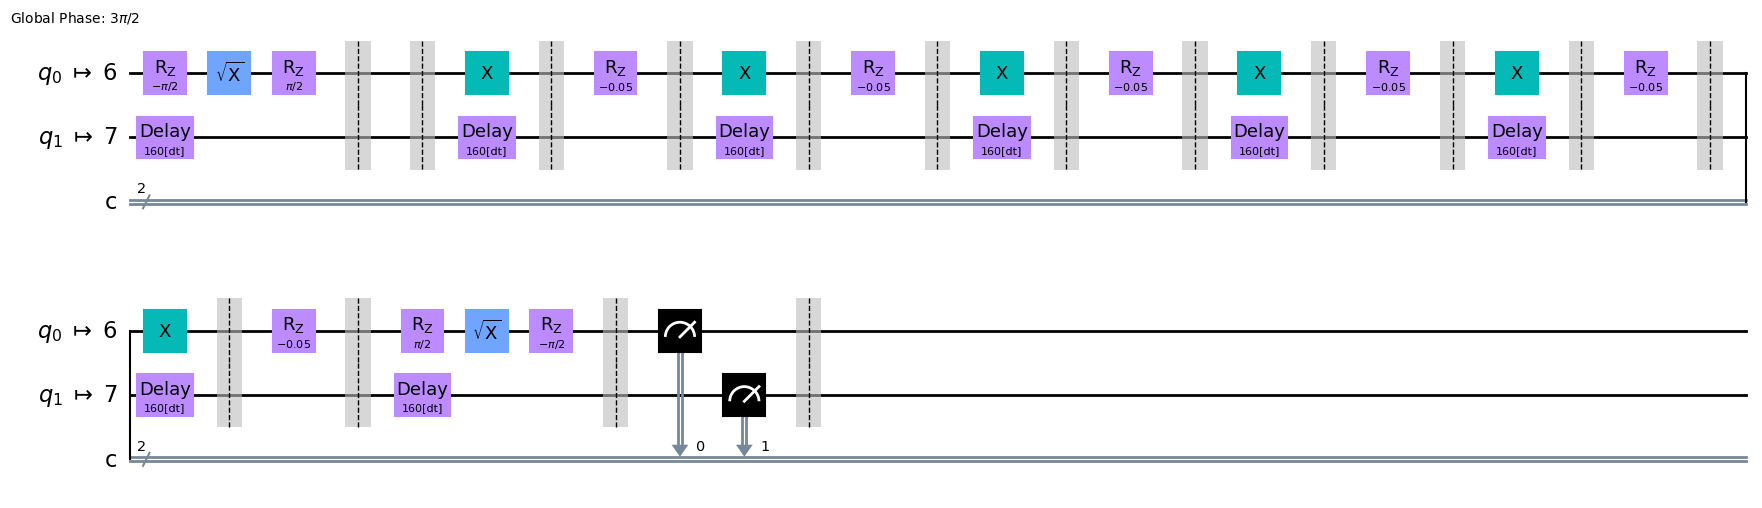

In [13]:
circ_list[3].draw('mpl',idle_wires=False)

In [75]:
result = backend.run(circ_list,shots=total_shots).result()

In [76]:
#USEFUL FUNCTIONS

def list1d_to_arr2d(lst,nrow,ncol):
    a = np.array(lst).reshape(nrow,ncol)
    return a

def consolidate_counts(count_list,value_list):
    #Adds together counts from different outputs. For ex, will add counts from '00' and '01' together
    total = 0
    for i in range(len(value_list)):
        a = count_list.get(value_list[i])
        try:
            total += a
        except:
            total += 0
    return total

def parse_data(output_data,num_angles,num_iterations,Nshots,pm):
    #parses output_data.get_counts() into different arrays
    cts = output_data.get_counts()
    Ncircuits = len(cts)
    if pm == 'plus':
        cts = cts[:int(Ncircuits/2)]
    elif pm == 'minus':
        cts = cts[int(Ncircuits/2):]
    else:
        cts = cts
    data_driven = np.zeros((num_angles,num_iterations))
    data_spec = np.zeros((num_angles,num_iterations))
    counts = list1d_to_arr2d(cts,num_angles,num_iterations)
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            data_driven[i,j] = consolidate_counts(counts[i,j],['01','11'])/Nshots
            data_spec[i,j] = consolidate_counts(counts[i,j],['10','11'])/Nshots
    return data_driven, data_spec

 

In [77]:
#Get parsed data
data_driven_p , data_spec_p = parse_data(result,N_angles,N_iterations,total_shots,'plus')
data_driven_m , data_spec_m = parse_data(result,N_angles,N_iterations,total_shots,'minus')
data_all = [data_driven_p, data_spec_p,data_driven_m,data_spec_m]

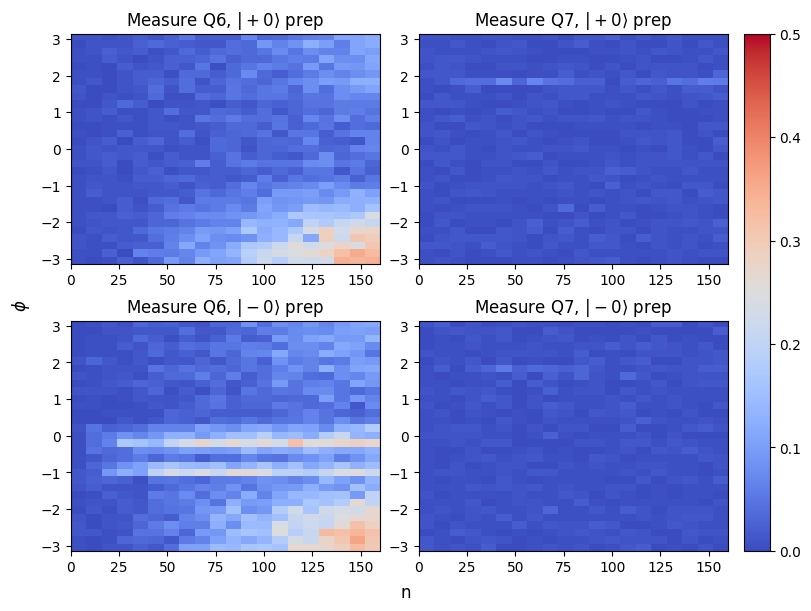

In [78]:
#Plot results
fig,axs = plt.subplots(2,2,figsize=(8,6),dpi=100,constrained_layout=True)
normto = 0.5

idx = 0
for i in range(2):
    for j in range(2):
        axs[i,j].imshow(data_all[idx],cmap='coolwarm',vmin=0,vmax=normto,extent=[0,N_iterations*mults,angle_min,angle_max],aspect='auto')
        idx += 1

axs[0,0].set_title(r'Measure Q6, $|+0\rangle$ prep')
axs[0,1].set_title(r'Measure Q7, $|+0\rangle$ prep')
axs[1,0].set_title(r'Measure Q6, $|-0\rangle$ prep')
axs[1,1].set_title(r'Measure Q7, $|-0\rangle$ prep')

fig.supylabel('$\phi$')
fig.supxlabel('n')

sm =  ScalarMappable(norm=norm,cmap='coolwarm')
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs[:,1])

In [ ]:
#Get parsed data
data_driven_p , data_spec_p = parse_data(result,N_angles,N_iterations,total_shots,'none')
data_driven_m , data_spec_m = parse_data(result,N_angles,N_iterations,total_shots,'none')
data_all = [data_driven_p, data_spec_p,data_driven_m,data_spec_m]
labels = [r'Measure Q6, $|+0\rangle$ prep',r'Measure Q7, $|+0\rangle$ prep',
          r'Measure Q6, $|-0\rangle$ prep',r'Measure Q7, $|-0\rangle$ prep']

#Plot results
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3),dpi=100,constrained_layout=True,sharex=True,sharey=True)
normto = 0.2
norm = plt.Normalize(0,normto)


ax1.imshow(data_all[0],cmap='coolwarm',vmin=0,vmax=normto,extent=[0,N_iterations,angle_min,angle_max],aspect='auto')
ax2.imshow(data_all[1],cmap='coolwarm',vmin=0,vmax=normto,extent=[0,N_iterations,angle_min,angle_max],aspect='auto')

ax1.set_title(r'Measure Q6, $|00\rangle$ prep')
ax2.set_title(r'Measure Q7, $|00\rangle$ prep')


fig.supylabel('$\phi$')
fig.supxlabel('n')

sm =  ScalarMappable(norm=norm,cmap='coolwarm')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)

In [ ]:
#Unused stuff (doesn't quite work...)

def get_calibrated_pulses(qubit):
    X90p = backend.defaults().instruction_schedule_map.get('sx', 6).instructions[0][1].pulse
    Xp = backend.defaults().instruction_schedule_map.get('x', 6).instructions[0][1].pulse
    drive_channel = pulse.DriveChannel(qubit)

    X90p_waveform = X90p.get_waveform().samples
    Y90p = np.imag(X90p_waveform)+1j*np.real(X90p_waveform)
    Y90m = np.imag(X90p_waveform)-1j*np.real(X90p_waveform)
    Y90p = library.Waveform(Y90p,'Y90p')
    Y90m = library.Waveform(Y90m,'Y90m')
    return drive_channel, X90p, Xp, Y90p, Y90m

def get_gate_fc(gate,drivechan,frame):
    with pulse.build(backend,name='gate_fc') as gate_fc:
        pulse.shift_phase(-frame,drivechan)
        pulse.play(gate,drivechan)
        pulse.shift_phase(frame,drivechan)
    return gate_fc

def frame_change(frame,drivechan):
    with pulse.build(backend,name='fc') as fc_sched:
        pulse.shift_phase(-frame,drivechan)
    return fc_sched

def build_spectator_circuit(driven_qubit,spectator_qubit,sign,phi,total_reps):
    d0, X90p_q0, Xp_q0, Y90p_q0, Y90m_q0 = get_calibrated_pulses(driven_qubit)
    d1, X90p_q1, Xp_q1, Y90p_q1, Y90m_q1 = get_calibrated_pulses(spectator_qubit)

    X90p_gates = [Gate('X90p_fc%d' %(i),1,[]) for i in range(total_reps)]
    Xp_gates = [Gate('Xp_fc%d' %(i),1,[]) for i in range(total_reps)]
    final_FC = Gate('FC',1,[])

    circ = QuantumCircuit(2,2)
    circ.ry(sign*pi/2,0)
    circ.barrier()
    
    for rep in range(total_reps):
        circ.append(X90p_gates[rep],[0])
        circ.barrier()
        circ.append(Xp_gates[rep],[0])
        circ.barrier()
    circ.append(final_FC,[0])
    circ.barrier()
    circ.ry(-sign*pi/2,0)
    circ.measure([0,1],[0,1])

    #add calibrations
    for rep in range(total_reps):
        circ.add_calibration('X90p_fc%d' %(rep),[driven_qubit],get_gate_fc(X90p_q0,d0,rep*phi))
        circ.add_calibration('Xp_fc%d' %(rep),[driven_qubit],get_gate_fc(Xp_q0,d0,phi/2+rep*phi))
    circ.add_calibration('FC',[0],frame_change(total_reps*phi,d0))

    circ_transpiled = transpile(circ,backend,initial_layout=[driven_qubit,spectator_qubit])
    return circ_transpiled

qc=build_spectator_circuit(0,1,1,0.43,2)
# qc.draw('mpl',idle_wires=False)
sched = build_schedule(qc,backend)
sched.draw()

#This section makes a list of circuits for running the spectator expt using pulse scheduler method


def build_spectator_expt_schedule(driven_qubit,spectator_qubit,pm,phi,total_reps):
    d0, X90p_q0, Xp_q0, Y90p_q0, Y90m_q0 = get_calibrated_pulses(driven_qubit)
    d1, X90p_q1, Xp_q1, Y90p_q1, Y90m_q1 = get_calibrated_pulses(spectator_qubit)
    if pm == 'plus':
        ygates = [Y90p_q0,Y90m_q0]
    if pm == 'minus':
        ygate = [Y90m_q0,Y90p,q0]
    with pulse.build(backend,name='spec_expt') as spec_sched:
        with pulse.align_sequential():
            pulse.play(ygates[0],d0)
            for rep in range(total_reps):
                pulse.shift_phase(-rep*phi,d0)
                pulse.play(X90p_q0,d0)
                pulse.shift_phase(rep*phi,d0)

                pulse.shift_phase(-phi/2-rep*phi,d0)
                pulse.play(Xp_q0,d0)
                pulse.shift_phase(phi/2+rep*phi,d0)

            pulse.shift_phase(-total_reps*phi,d0)
            pulse.play(ygates[1],d0)
            
            pulse.measure([driven_qubit,spectator_qubit],[pulse.MemorySlot(driven_qubit),pulse.MemorySlot(spectator_qubit)])
    return spec_sched



def build_circuit_list_spectator_expt(driven_qubit,spectator_qubit,angle_min,angle_max,N_angles,Nits):
    phi_list = np.linspace(angle_min,angle_max,N_angles)
    circ_list = []
    for k in range(2):
        if k == 0:
            pm = 'plus'
        if k == 1:
            pm == 'minus'
        for i in range(len(phi_list)):
            for reps in range(Nits):
                qc = build_spectator_circuit(driven_qubit,spectator_qubit,pm,phi_list[i],reps)
                circ_list.append(qc)
    return circ_list

qc=build_spectator_circuit(6,7,1,0.43,2)
qc.draw('mpl',idle_wires=False)
# sched = build_schedule(qc,backend)
# sched.draw()

driven_qubit = 6
spectator_qubit = 7
N_angles = 51
N_iterations = 80
total_shots = 200
angle_min = -pi
angle_max = pi

circ_list = build_circuit_list_spectator_expt(driven_qubit,spectator_qubit,angle_min,angle_max,N_angles,N_iterations)